In [1]:
# %env WANDB_PROJECT=nlu_sentiment_analysis
# !wandb login 2cad8a8279143c69ce071f54bf37c1f5a5f4e5ff
# import wandb

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import itertools
import requests, re, string, datetime, copy
from functools import partial

import torch
import torchvision.transforms as T, torch.nn.functional as F, torch.nn as nn
from torch.utils.data import DataLoader

from datasets import Dataset
from transformers import TrainingArguments, EarlyStoppingCallback, TrainerCallback
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, get_linear_schedule_with_warmup
from transformers.modeling_outputs import SequenceClassifierOutput

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score

import plotly.graph_objects as go

PATH = "./data/"
device = "cpu"

In [2]:
def plot_confidence_distribution(trues, preds, proba, name, dataset, plot_neutral, adjust_positive=False):
    false_negatives = np.logical_and(trues != 0, preds == 0)
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=proba[false_negatives, np.argmax(proba[false_negatives,:], axis=1)], 
                               xbins=dict(
                                start=0.,
                                end=1.0,
                                size=0.1
                                ), 
                               histnorm='probability'))
    fig.update_layout(
        title=f"{name}'s confidence distribution for {dataset} - false negatives",
        xaxis_title="confidence",
        yaxis_title="normalized count",
    )
    fig.update_xaxes(range=[0., 1.])
    fig.show()

    if plot_neutral:
        false_neutrals = np.logical_and(trues != 1, preds == 1)
        fig = go.Figure()
        fig.add_trace(go.Histogram(x=proba[false_neutrals, np.argmax(proba[false_neutrals,:], axis=1)], 
                                   xbins=dict(
                                    start=0.,
                                    end=1.0,
                                    size=0.1
                                    ), 
                                   histnorm='probability'))
        fig.update_layout(
            title=f"{name}'s confidence distribution for {dataset} - false neutrals",
            xaxis_title="confidence",
            yaxis_title="normalized count",
        )
        fig.update_xaxes(range=[0., 1.])
        fig.show()

    false_positives = np.logical_and(trues != 2, preds == 2) if not adjust_positive else np.logical_and(trues != 1, preds == 1)
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=proba[false_positives, np.argmax(proba[false_positives,:], axis=1)], 
                               xbins=dict(
                                start=0.,
                                end=1.0,
                                size=0.1
                                ), 
                               histnorm='probability'))
    fig.update_layout(
        title=f"{name}'s confidence distribution for {dataset} - false positives",
        xaxis_title="confidence",
        yaxis_title="normalized count",
    )
    fig.update_xaxes(range=[0., 1.])
    fig.show()

In [41]:
"""Tokenization classes for Italian AlBERTo models."""
import collections
import os

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'user', 'percent', 'money', 'phone', 'time', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag"},
    fix_html=True,  # fix HTML tokens

    unpack_hashtags=True,  # perform word segmentation on hashtags

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[emoticons]
)

class AlBERTo_Preprocessing(object):
    def __init__(self, do_lower_case=True, **kwargs):
        self.do_lower_case = do_lower_case

    def preprocess(self, text):
        if self.do_lower_case:
            text = text.lower()
        text = str(" ".join(text_processor.pre_process_doc(text)))
        text = re.sub(r'[^a-zA-ZÀ-ú</>!?♥♡\s\U00010000-\U0010ffff]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
        text = re.sub(r'^\s', '', text)
        text = re.sub(r'\s$', '', text)
        return text

a = AlBERTo_Preprocessing(do_lower_case=True)
s = "#IlGOverno presenta le linee guida sulla scuola #labuonascuola - http://t.co/SYS1T9QmQN"
b = a.preprocess(s)
print(b)

Reading english - 1grams ...
Reading english - 2grams ...
Reading english - 1grams ...
<hashtag> il governo </hashtag> presenta le linee guida sulla scuola <hashtag> la buona scuola </hashtag> <url>


In [25]:
from transformers import AutoTokenizer, AutoModel

def tokenize_function(examples):
    sa = tok(examples["text"], padding="max_length", truncation=True)
    return sa

a = AlBERTo_Preprocessing(do_lower_case=True)
s: str = "#IlGOverno presenta le linee guida sulla scuola #labuonascuola - http://t.co/SYS1T9QmQN"
b = a.preprocess(s)

tok = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
pretrained_model = AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
tok.model_max_length = 128 #model.config.max_position_embeddings
tokens = tok.tokenize(b)
print(tokens)

['<', 'ha', '##shtag', '>', 'il', 'governo', '<', '/', 'ha', '##shtag', '>', 'presenta', 'le', 'linee', 'guida', 'sulla', 'scuola', '<', 'ha', '##shtag', '>', 'la', 'buona', 'scuola', '<', '/', 'ha', '##shtag', '>', '<', 'ur', '##l', '>']


In [5]:
class MyNetMC(nn.Module):
    """
        Attach a FC layer on top of the BERT head in order to produce a classification output.

        The pooled_output output of BERT is basically a projection of the [CLS] embeddings via another FC layer (768 -> 768 hidden units).
        We stack another FC layer with Dropout on top of that, as reported in https://github.com/google-research/bert/blob/eedf5716ce1268e56f0a50264a88cafad334ac61/run_classifier.py#L574
    """
    def __init__(self, num_labels):
        super(MyNetMC, self).__init__()

        self.num_labels = num_labels
        self.model = copy.deepcopy(pretrained_model)#AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
        self.dropout1 = nn.Dropout(0.1)
        self.linear1 = nn.Linear(768, 3)

        self.loss_fct = nn.CrossEntropyLoss()


    def forward(self, labels, input_ids, attention_mask, **args):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **args)
        x = self.dropout1(outputs[1])
        logits = self.linear1(x)
        loss = self.loss_fct(logits, labels)
        return logits , loss
    
class MyNetMCTuned(nn.Module):
    """
        Attach a FC layer on top of the BERT head in order to produce a classification output.

        The pooled_output output of BERT is basically a projection of the [CLS] embeddings via another FC layer (768 -> 768 hidden units).
        We stack another FC layer without Dropout on top of that, as reported in https://github.com/google-research/bert/blob/eedf5716ce1268e56f0a50264a88cafad334ac61/run_classifier.py#L574
    """
    def __init__(self, num_labels):
        super(MyNetMCTuned, self).__init__()

        self.num_labels = num_labels
        self.model = copy.deepcopy(pretrained_model)
        self.linear = nn.Linear(768, 3)

        self.loss_fct = nn.CrossEntropyLoss()

    def forward(self, labels, input_ids, attention_mask, **args):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **args)
        logits = self.linear(outputs[1])
        loss = self.loss_fct(logits, labels)
        return logits , loss

In [19]:
def validation_epoch(model, epoch, val_loader, kind, logging):
    model.eval()
    targets , outputs , logitss = [] , [] , []
    cumulative_loss = 0.
    with torch.no_grad():
        for i , data in enumerate(val_loader, 0):
            batch = {k: v.to(device) for k, v in data.items()}
            logits , loss = model(**batch)
            cumulative_loss += loss.detach()
            if (i+1) % 25 == 0 and logging:
                print(f'Epoch: {epoch}, Loss:  {cumulative_loss.item()/i}')
            
            targets.extend(batch["labels"].cpu().detach().numpy())
            outputs.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
            logitss.extend(logits.cpu().detach().numpy().tolist())
    if logging: wandb.log({kind: {'loss': cumulative_loss.item() / len(outputs)}})
    return outputs, targets, logitss

# SENTIPOLC16

In [2]:
train_sentipolc = pd.read_csv(PATH + "Sentipolc16/training_set_sentipolc16.csv")

In [3]:
file1 = open(PATH + "Sentipolc16/test_set_sentipolc16_gold2000.csv", 'r') 
Lines = file1.readlines()
 
test_sentipolc = []
for line in Lines:
  arr = line.split("\",")
  if len(arr) != 9:
    arr[8] = arr[8] + arr[9]  #to account for tweets containing the delimiter charachter that would create more splits than needed
    del arr[9:]
  for i in range(8):
    arr[i] = int(arr[i].strip("\""))
  test_sentipolc.append(arr)

test_sentipolc = pd.DataFrame(test_sentipolc, columns=train_sentipolc.columns)
test_sentipolc.head()

,idtwitter,subj,opos,oneg,iro,lpos,lneg,top,text
0,507074506880712705,0,0,0,0,0,0,2,"""Tra 5 minuti presentazione piano scuola del g..."
1,507075789456961536,1,1,0,0,1,0,2,"""\""@matteorenzi: Alle 10 appuntamento su http:..."
2,507077511902425088,1,0,1,0,0,1,2,"""#labuonascuola gli #evangelisti #digitali non..."
3,507079183315787777,0,0,0,0,0,0,2,"""Riforma scuola Tutto il discorso di Renzi su..."
4,507080190225563648,1,0,0,0,0,0,2,""".@matteorenzi @MiurSocial #labuonascuola bast..."


In [8]:
def separate2united_labels(row):
    """
        Return a single scalar integer label associated to the polarity of the tweet.

        Negative -> 0
        Neutral  -> 1
        Positive -> 2
        Mixed    -> 3
    """
    if row["opos"] == 0 and row["oneg"] == 0:
        return 1
    elif row["oneg"] == 0 and row["opos"] == 1:
        return 2
    elif row["oneg"] == 1 and row["opos"] == 0:
        return 0
    else:
        return 3


dataset = pd.DataFrame({"text": test_sentipolc.text.apply(a.preprocess), "idx": test_sentipolc.index, "labels": test_sentipolc[["opos", "oneg"]].apply(separate2united_labels, axis=1)})
dataset = Dataset.from_pandas(dataset)

testing_sentipolc = dataset\
                    .map(tokenize_function, batched=True)\
                    .filter(lambda example: example['labels'] != 3)\
                    .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])

### AlBERTo pretrained - SENTIPOLC16

              precision    recall  f1-score   support

    negative       0.85      0.51      0.64       734
     neutral       0.70      0.78      0.74       914
    positive       0.44      0.69      0.54       316

    accuracy                           0.67      1964
   macro avg       0.66      0.66      0.64      1964
weighted avg       0.71      0.67      0.67      1964



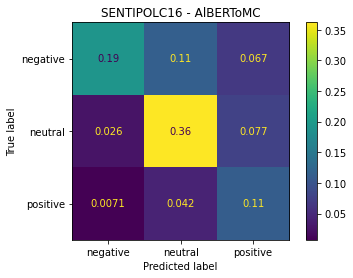

In [22]:
test_loader_sentipolc = DataLoader(testing_sentipolc, batch_size=64)

#load best model's params
model = MyNetMC(3).to(device)
model.load_state_dict(torch.load("data/models/alberto_multiclass.pt"))

preds , trues , logitss = validation_epoch(model, None, test_loader_sentipolc, "test", logging=False)
        
# for n , (i , row) in enumerate(dataset_feel_it.iterrows()):
#     if preds[n] != trues[n]:
#         print(f"{row['text']} ------ true={row['labels']} pred={preds[n]}  \n")
#         assert row['labels'] == trues[n]
        
print(classification_report(trues, preds, target_names=["negative", "neutral", "positive"]))

cm = confusion_matrix(trues, preds, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"]).plot()
plt.title("SENTIPOLC16 - AlBERToMC")


# plot the confidence distribution for errors
proba = torch.nn.functional.softmax(torch.tensor(logitss), dim=1)
trues = np.array(trues)
preds = np.array(preds)

plot_confidence_distribution(trues, preds, proba, name="AlBERToMC", dataset="SENTIPOLC", plot_neutral=True)

### AlBERTo with hyper-params tuned - SENTIPOLC16

              precision    recall  f1-score   support

    negative       0.85      0.55      0.67       734
     neutral       0.70      0.85      0.76       914
    positive       0.53      0.63      0.58       316

    accuracy                           0.70      1964
   macro avg       0.69      0.68      0.67      1964
weighted avg       0.73      0.70      0.70      1964



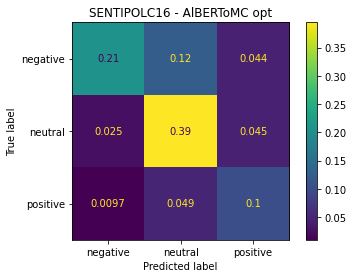

In [23]:
test_loader_sentipolc = DataLoader(testing_sentipolc, batch_size=64)

#load best model's params
model = MyNetMCTuned(3).to(device)
model.load_state_dict(torch.load("data/models/alberto_multiclass_tuned.pt"))

preds , trues , logitss = validation_epoch(model, None, test_loader_sentipolc, "test", logging=False)
        
# for n , (i , row) in enumerate(dataset_feel_it.iterrows()):
#     if preds[n] != trues[n]:
#         print(f"{row['text']} ------ true={row['labels']} pred={preds[n]}  \n")
#         assert row['labels'] == trues[n]
        
print(classification_report(trues, preds, target_names=["negative", "neutral", "positive"]))

cm = confusion_matrix(trues, preds, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"]).plot()
plt.title("SENTIPOLC16 - AlBERToMC opt")


# plot the confidence distribution for errors
proba = torch.nn.functional.softmax(torch.tensor(logitss), dim=1)
trues = np.array(trues)
preds = np.array(preds)

plot_confidence_distribution(trues, preds, proba, name="AlBERToMC opt", dataset="SENTIPOLC", plot_neutral=True)

### Feel-it model - SENTIPOLC16
Note that it was trained just for positive/negative class, so the neutral class is taken for examples with low confidence in the prediction.


              precision    recall  f1-score   support

    negative       0.61      0.89      0.72       734
     neutral       0.50      0.00      0.00       914
    positive       0.29      0.80      0.42       316

    accuracy                           0.46      1964
   macro avg       0.46      0.56      0.38      1964
weighted avg       0.50      0.46      0.34      1964



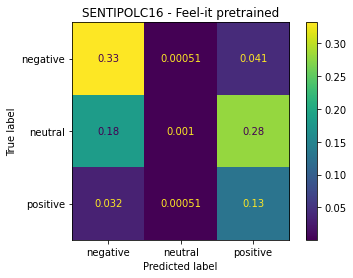

In [21]:
tok_feelit = AutoTokenizer.from_pretrained("MilaNLProc/feel-it-italian-sentiment")
tok_feelit.model_max_length = 128

model = AutoModelForSequenceClassification.from_pretrained("MilaNLProc/feel-it-italian-sentiment").to(device)
model.eval()

dataset = pd.DataFrame({"text": test_sentipolc.text.apply(a.preprocess), "idx": test_sentipolc.index, "labels": test_sentipolc[["opos", "oneg"]].apply(separate2united_labels, axis=1)})
dataset = Dataset.from_pandas(dataset)
testing = dataset\
                .map(lambda examples: tok_feelit(examples["text"], padding="max_length", truncation=True), batched=True)\
                .filter(lambda example: example['labels'] != 3)\
                .with_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_loader = DataLoader(testing, batch_size=64)


trues , preds , logitss = [] , [] , []
with torch.no_grad():
    for _, data in enumerate(test_loader, 0):
        batch = {k: data[k].to(device) for k in ['attention_mask', 'input_ids']}
        logits = model(**batch)[0]
        trues.extend(data["labels"].detach().numpy())
        preds.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
        logitss.extend(logits.cpu().detach().numpy().tolist()) #logits = logits.squeeze(0)
        
        
proba = torch.nn.functional.softmax(torch.tensor(logitss), dim=1)

assert len(preds) == len(proba) and np.all(np.array((proba[:,1] + proba[:,0]) >= 0.99))
for i in range(len(proba)):
    if preds[i] == 1: #the net produces just [0,1] for positive/negative, so adjust label
        preds[i] = 2
    if max(proba[i,0] , proba[i, 1]) <= 0.55: #set to neutral  if the prediction's confidence is too low
        preds[i] = 1

print(classification_report(trues, preds, target_names=["negative", "neutral", "positive"]))
cm = confusion_matrix(trues, preds, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"]).plot()
plt.title("SENTIPOLC16 - Feel-it pretrained")

# plot the confidence distribution for errors

trues = np.array(trues)
preds = np.array(preds)

plot_confidence_distribution(trues, preds, proba, name="Feel-it model", dataset="SENTIPOLC", plot_neutral=True)

### Feel-it model - SENTIPOLC16
Excluding neutral tweets


              precision    recall  f1-score   support

    negative       0.91      0.89      0.90       734
    positive       0.76      0.80      0.78       316

    accuracy                           0.86      1050
   macro avg       0.83      0.84      0.84      1050
weighted avg       0.86      0.86      0.86      1050



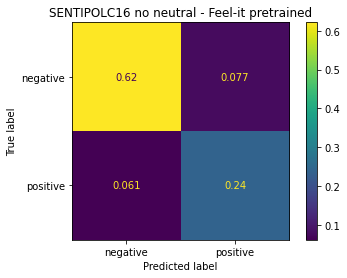

In [32]:
tok_feelit = AutoTokenizer.from_pretrained("MilaNLProc/feel-it-italian-sentiment")
tok_feelit.model_max_length = 128

model = AutoModelForSequenceClassification.from_pretrained("MilaNLProc/feel-it-italian-sentiment").to(device)
model.eval()

dataset = pd.DataFrame({"text": test_sentipolc.text.apply(a.preprocess), "idx": test_sentipolc.index, "labels": test_sentipolc[["opos", "oneg"]].apply(separate2united_labels, axis=1)})
dataset = Dataset.from_pandas(dataset)
testing = dataset\
                .map(lambda examples: tok_feelit(examples["text"], padding="max_length", truncation=True), batched=True)\
                .filter(lambda example: example['labels'] != 3)\
                .filter(lambda example: example['labels'] != 1)\
                .with_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_loader = DataLoader(testing, batch_size=64)


trues , preds , logitss = [] , [] , []
with torch.no_grad():
    for _, data in enumerate(test_loader, 0):
        batch = {k: data[k].to(device) for k in ['attention_mask', 'input_ids']}
        logits = model(**batch)[0]
        trues.extend(data["labels"].detach().numpy())
        preds.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
        logitss.extend(logits.cpu().detach().numpy().tolist()) #logits = logits.squeeze(0)
        
        
proba = torch.nn.functional.softmax(torch.tensor(logitss), dim=1)

assert len(preds) == len(proba) and np.all(np.array((proba[:,1] + proba[:,0]) >= 0.99))
for i in range(len(proba)):
    if trues[i] == 2: #the net produces just [0,1] for positive/negative, so adjust label
        trues[i] = 1

print(classification_report(trues, preds, target_names=["negative", "positive"]))
cm = confusion_matrix(trues, preds, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"]).plot()
plt.title("SENTIPOLC16 no neutral - Feel-it pretrained")

# plot the confidence distribution for errors
trues = np.array(trues)
preds = np.array(preds)
plot_confidence_distribution(trues, preds, proba, name="Feel-it model", dataset="SENTIPOLC no neutral", plot_neutral=False, adjust_positive=True)

# FEEL-IT dataset

In [16]:
train_feel_it = pd.read_csv(PATH + "Feel-it/feelit.tsv", sep='\t', header=0, names=["text", "label"])
print("\nAverage tweet lenght: ", np.mean(train_feel_it["text"].apply(len)))
train_feel_it.head()


Average tweet lenght:  141.8939617083947


,text,label
0,"@USER Adoro questa canzone, è una delle mie pr...",joy
1,#MilanNovara È arrivato il 3 gol del MILAN ❤🖤...,joy
2,stream icarus falls 🖤 zayn ha un talento ed è ...,sadness
3,Persona di indiscutibile cultura #Daverio avev...,sadness
4,Oggi la direttrice @USER ha spiegato che #COVI...,fear


In [23]:
def emotion2sentiment(row):
    """
        Return a single scalar integer label associated to the emotion of the tweet.

        joy -> 2
        anger sadness fear  -> 0
    """
    if row["label"] == "joy":
        return 2
    elif row["label"] == "sadness" or row["label"] == "fear" or row["label"] == "anger":
        return 0
    else:
        raise ValueError('Value not recognized')

#train set
dataset_feel_it = pd.DataFrame({"text": train_feel_it.text.apply(a.preprocess), "idx": train_feel_it.index, "labels": train_feel_it[["label"]].apply(emotion2sentiment, axis=1)})
dataset = Dataset.from_pandas(dataset_feel_it)

testing__feel_it = dataset\
                    .map(tokenize_function, batched=True)\
                    .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])

In [35]:
testing__feel_it["text"][:5]

['<user> adoro questa canzone è una delle mie preferite 😍 😍 😍 stream icarus falls',
 '<hashtag> milan novara </hashtag> è arrivato il <number> gol del milan 🖤 dicevamo <hashtag> sempre milan </hashtag> 💥 💥',
 'stream icarus falls 🖤 zayn ha un talento ed è ingiusto ciò che gli è stato fatto <sad> <url>',
 'persona di indiscutibile cultura <hashtag> daverio </hashtag> aveva il raro dono di farti appassionare a ciò che lui per primo amava l arte e la bellezza tutto quello che ci ha insegnato non andrà perduto resterà nel tempo come le cattedrali i quadri le opere di cui tanto ci ha parlato rip <url>',
 'oggi la direttrice <user> ha spiegato che <hashtag> covid </hashtag> in rialzo ma non preoccupante perché molti più <hashtag> tam poni </hashtag> numero <hashtag> rico veri </hashtag> molto basso nei paesi in cui si è tornati a <hashtag> scuola </hashtag> no aumento <hashtag> cont agi </hashtag> perché allora <hashtag> governo </hashtag> e <hashtag> media </hashtag> stanno ricreando clima 

### AlBERTo pretrained - FEEL-IT
Recall that FEEL_IT does not have neutral tweets, but AlBERTo was trained with such class

              precision    recall  f1-score   support

    negative       0.95      0.83      0.89      1309
     neutral       0.00      0.00      0.00         0
    positive       0.83      0.83      0.83       728

    accuracy                           0.83      2037
   macro avg       0.59      0.55      0.57      2037
weighted avg       0.91      0.83      0.87      2037



/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



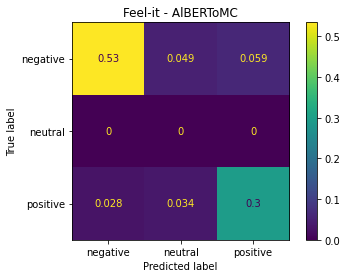

In [24]:
test_loader_feel_it = DataLoader(testing__feel_it, batch_size=64)

#load best model's params
model = MyNetMC(3).to(device)
model.load_state_dict(torch.load("data/models/alberto_multiclass.pt"))

preds , trues , logitss = validation_epoch(model, None, test_loader_feel_it, "test", logging=False)
        
# for n , (i , row) in enumerate(dataset_feel_it.iterrows()):
#     if preds[n] != trues[n]:
#         print(f"{row['text']} ------ true={row['labels']} pred={preds[n]}  \n")
#         assert row['labels'] == trues[n]
        
print(classification_report(trues, preds, target_names=["negative", "neutral", "positive"]))

cm = confusion_matrix(trues, preds, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"]).plot()
plt.title("Feel-it - AlBERToMC")


# plot the confidence distribution for errors
trues = np.array(trues)
preds = np.array(preds)
proba = torch.nn.functional.softmax(torch.tensor(logitss), dim=1)

plot_confidence_distribution(trues, preds, proba, name="AlBERToMC", dataset="Feel-IT", plot_neutral=True)

### AlBERTo opt - Feel-IT

              precision    recall  f1-score   support

    negative       0.94      0.84      0.88      1309
     neutral       0.00      0.00      0.00         0
    positive       0.82      0.84      0.83       728

    accuracy                           0.84      2037
   macro avg       0.59      0.56      0.57      2037
weighted avg       0.90      0.84      0.86      2037



/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



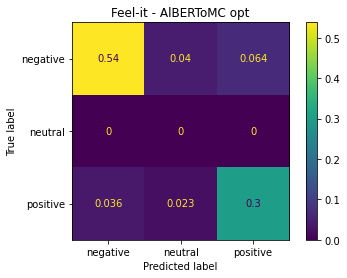

In [38]:
test_loader_feel_it = DataLoader(testing__feel_it, batch_size=64)

#load best model's params
model = MyNetMCTuned(3).to(device)
model.load_state_dict(torch.load("data/models/alberto_multiclass_tuned.pt"))

preds , trues , logitss = validation_epoch(model, None, test_loader_feel_it, "test", logging=False)
        
# for n , (i , row) in enumerate(dataset_feel_it.iterrows()):
#     if preds[n] != trues[n]:
#         print(f"{row['text']} ------ true={row['labels']} pred={preds[n]}  \n")
#         assert row['labels'] == trues[n]
        
print(classification_report(trues, preds, target_names=["negative", "neutral", "positive"]))

cm = confusion_matrix(trues, preds, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"]).plot()
plt.title("Feel-it - AlBERToMC opt")


# plot the confidence distribution for errors
trues = np.array(trues)
preds = np.array(preds)
proba = torch.nn.functional.softmax(torch.tensor(logitss), dim=1)

plot_confidence_distribution(trues, preds, proba, name="AlBERToMC opt", dataset="Feel-IT", plot_neutral=True)

### FEEL_IT model - FEEL_IT dataset


              precision    recall  f1-score   support

    negative       0.99      0.99      0.99      1309
    positive       0.97      0.99      0.98       728

    accuracy                           0.99      2037
   macro avg       0.98      0.99      0.99      2037
weighted avg       0.99      0.99      0.99      2037



Text(0.5, 1.0, 'Feel-it - Feel-it pretrained')

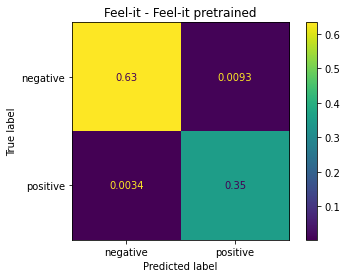

In [39]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tok_feelit = AutoTokenizer.from_pretrained("MilaNLProc/feel-it-italian-sentiment")
tok_feelit.model_max_length = 128

model = AutoModelForSequenceClassification.from_pretrained("MilaNLProc/feel-it-italian-sentiment").to(device)
model.eval()

dataset_feel_it = pd.DataFrame({"text": train_feel_it.text.apply(a.preprocess), "idx": train_feel_it.index, "labels": train_feel_it[["label"]].apply(emotion2sentiment, axis=1)})
dataset = Dataset.from_pandas(dataset_feel_it)

testing__feel_it = dataset\
                    .map(lambda examples: tok_feelit(examples["text"], padding="max_length", truncation=True), batched=True)\
                    .with_format("torch", columns=["input_ids", "attention_mask", "labels"])

test_loader_feel_it = DataLoader(testing__feel_it, batch_size=64)

trues , preds , logitss = [] , [] , []
with torch.no_grad():
    for _, data in enumerate(test_loader_feel_it, 0):
        batch = {k: data[k].to(device) for k in ['attention_mask', 'input_ids']}
        logits = model(**batch)[0]
        trues.extend(data["labels"].detach().numpy())
        preds.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
        logitss.extend(logits.cpu().detach().numpy().tolist()) #logits = logits.squeeze(0)
        
        
proba = torch.nn.functional.softmax(torch.tensor(logitss), dim=1)

assert len(preds) == len(proba) and np.all(np.array((proba[:,1] + proba[:,0]) >= 0.99))
for i in range(len(proba)):
    if trues[i] == 2: #the net produces just [0,1] for positive/negative, so adjust label
        trues[i] = 1

print(classification_report(trues, preds, target_names=["negative", "positive"]))
cm = confusion_matrix(trues, preds, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"]).plot()
plt.title("Feel-it - Feel-it pretrained")

# Amazon reviews

In [42]:
amazon = pd.read_json(PATH + "Amazon-reviews/Amazon_reviews_computer_cloths_food_shoaps.json")
amazon["text"] = amazon["title"] + ": " +  amazon["text"]
print(len(amazon) , np.unique(amazon.rating, return_counts=True))
print("\nAverage review lenght: ", np.mean(amazon["text"].apply(len)))
amazon.head()

1172 (array([1, 2, 3, 4, 5]), array([175,  77, 126, 196, 598]))

Average review lenght:  445.5255972696246


,title,text,rating
0,Facile e comodo,Facile e comodo: Comprato per sostituzione que...,5
1,Ottimo rapporto qualità prezzo,Ottimo rapporto qualità prezzo: Fa il suo dove...,5
2,aspirapolvere,aspirapolvere: L'aspirapolvere ha una grande p...,5
3,Mi piace,"Mi piace: Ottimo aspirapolvere.Prima di tutto,...",5
4,Peggiore mai avuto finora,Peggiore mai avuto finora: Prodotto apparentem...,1


In [47]:
def rating2sentiment(row):
    """
        Returns the polarity depending on the rating of the review
    """
    if row["rating"] == 3:
        return 1
    elif row["rating"] > 3:
        return 2
    elif row["rating"] < 3:
        return 0
    
#tok = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
#tok.model_max_length = 400

dataset_amazon = pd.DataFrame({"text": amazon.text.apply(a.preprocess), "idx": amazon.index, "labels": amazon[["rating"]].apply(rating2sentiment, axis=1)})
dataset = Dataset.from_pandas(dataset_amazon)

testing_amazon = dataset\
                    .map(tokenize_function, batched=True)\
                    .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])

In [50]:
testing_amazon["text"][0]

'facile e comodo comprato per sostituzione quello vecchio che mi si è rotto il pacco è arrivato velocissimo confezionato da amazon all interno del pacco trovo robot aspirapolvere il quelle sono scomparti da vali parti che è molto facile da montare basta incastrare sono molto contento dell acquisto perché questo aspirapolvere senza filo è <number> in <number> che è possibile utilizzare sia come una scopa elettrico per pulire pavimento sia come un aspirapolvere per pulire i tappeti o materasso soprattutto mi è piaciuto utilizzare per aspirale in auto che perché la potenza è decisamente più forte rispetto quelli del service self scopa elettrico è a touch perciò facilità molto nel pulire essi è composta da due livello di potenza e cambia automaticamente da potenza standard a quello super quando rileva un affaticamento di aspiro questo funzione mi permette di pulire più facile secondo me con questo prezzo la qualità è già molto conveniente rispetto altri prodotti simili'

### AlBERTo opt - Amazon reviews

              precision    recall  f1-score   support

    negative       0.39      0.80      0.52       252
     neutral       0.12      0.09      0.10       126
    positive       0.90      0.64      0.75       794

    accuracy                           0.61      1172
   macro avg       0.47      0.51      0.46      1172
weighted avg       0.71      0.61      0.63      1172



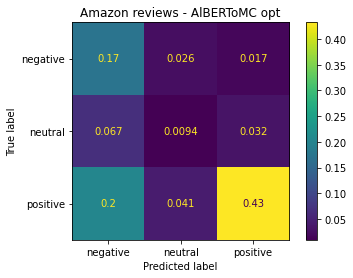

In [49]:
test_loader_amazon = DataLoader(testing_amazon, batch_size=64)

#load best model's params
model = MyNetMCTuned(3).to(device)
model.load_state_dict(torch.load("data/models/alberto_multiclass_tuned.pt"))

preds , trues , logitss = validation_epoch(model, None, test_loader_amazon, "test", logging=False)
        
# for n , (i , row) in enumerate(dataset_feel_it.iterrows()):
#     if preds[n] != trues[n]:
#         print(f"{row['text']} ------ true={row['labels']} pred={preds[n]}  \n")
#         assert row['labels'] == trues[n]
        
print(classification_report(trues, preds, target_names=["negative", "neutral", "positive"]))

cm = confusion_matrix(trues, preds, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"]).plot()
plt.title("Amazon reviews - AlBERToMC opt")


# plot the confidence distribution for errors
proba = torch.nn.functional.softmax(torch.tensor(logitss), dim=1)
trues = np.array(trues)
preds = np.array(preds)

#plot_confidence_distribution(trues, preds, proba, name="AlBERToMC opt", dataset="Amazon reviews", plot_neutral=True)

### AlBERTo opt - Amazon reviews with stop words removal

In [46]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

class AlBERTo_Preprocessing_Stop_words(object):
    def __init__(self, do_lower_case=True, **kwargs):
        self.do_lower_case = do_lower_case
        self.stop_words = set(stopwords.words('italian'))

    def preprocess(self, text):
        if self.do_lower_case:
            text = text.lower()
        text = text_processor.pre_process_doc(text)
        filtered_text = [w for w in text if not w in self.stop_words]
        text = str(" ".join(filtered_text))
        text = re.sub(r'[^a-zA-ZÀ-ú</>!?♥♡\s\U00010000-\U0010ffff]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
        text = re.sub(r'^\s', '', text)
        text = re.sub(r'\s$', '', text)
        return text

b = AlBERTo_Preprocessing_Stop_words(do_lower_case=True)

dataset_amazon = pd.DataFrame({"text": amazon.text.apply(b.preprocess), "idx": amazon.index, "labels": amazon[["rating"]].apply(rating2sentiment, axis=1)})
dataset = Dataset.from_pandas(dataset_amazon)
testing_amazon = dataset\
                    .map(tokenize_function, batched=True)\
                    .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])

test_loader_amazon = DataLoader(testing_amazon, batch_size=64)

#load best model's params
model = MyNetMCTuned(3).to(device)
model.load_state_dict(torch.load("data/models/alberto_multiclass_tuned.pt"))

preds , trues , logitss = validation_epoch(model, None, test_loader_amazon, "test", logging=False)        
print(classification_report(trues, preds, target_names=["negative", "neutral", "positive"]))

[nltk_data] Downloading package stopwords to /home/steve/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



              precision    recall  f1-score   support

    negative       0.36      0.70      0.48       252
     neutral       0.14      0.21      0.17       126
    positive       0.90      0.55      0.68       794

    accuracy                           0.54      1172
   macro avg       0.47      0.49      0.44      1172
weighted avg       0.70      0.54      0.58      1172

